TDがテストデータのとき

In [1]:
from asyncio.windows_events import NULL
import pandas as pd
import numpy as np
import re
import scipy
from scipy.spatial.transform import Rotation
from scipy.ndimage import rotate
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import japanize_matplotlib  # 日本語フォントを有効にするためのimport
import os
import csv
import cv2
from matplotlib.patches import Ellipse
import math
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import LeaveOneOut
import glob
from torch.utils.data import TensorDataset, DataLoader

# モデルの定義
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#訓練データ

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()


pattern = "開始2秒/TD/*/*/*/*.csv"

# パターンにマッチするファイルパスのリストを取得
file_paths = glob.glob(pattern)
dataframes_before_angle_right = []


for path in file_paths:
    data = pd.read_csv(path)
    data = data.iloc[:,1:]
    # 5列目のみに特定の変換を適用
    #data.iloc[:, 2] = data.iloc[:, 2].apply(lambda x: abs(180 - x) if x > 90 else x)
    dataframes_before_angle_right.append(data)
    # 右足のデータフレームの1列目と2列目を正規化
    for i in range(len(dataframes_before_angle_right)):

        dataframes_before_angle_right[i].iloc[:, 0:] = scaler.fit_transform(dataframes_before_angle_right[i].iloc[:, 0:])

# 各DataFrameをテンソルに変換する
tensor_list_right = []
for df in dataframes_before_angle_right:
    # DataFrameをNumpy配列に変換
    numpy_array = df.values

    # Numpy配列をPyTorchのテンソルに変換
    tensor_data = torch.tensor(numpy_array, dtype = torch.float32)

    # テンソルをリストに追加
    tensor_list_right.append(tensor_data)

"""

pattern = "TD_new/*/*/角度*左足*.csv"

# パターンにマッチするファイルパスのリストを取得
file_paths = glob.glob(pattern)
dataframes_before_angle_left = []

for path in file_paths:
    data = pd.read_csv(path)
    data = data.iloc[:,[1,3,4]]
    # 5列目のみに特定の変換を適用
    #data.iloc[:, 2] = data.iloc[:, 2].apply(lambda x: abs(180 - x) if x > 90 else x)
    dataframes_before_angle_left.append(data)
    for i in range(len(dataframes_before_angle_left)):
        dataframes_before_angle_left[i].iloc[:, [0, 1,2]] = scaler.fit_transform(dataframes_before_angle_left[i].iloc[:, [0, 1,2]])



tensor_list_left = []
for df in dataframes_before_angle_left:
    # DataFrameをNumpy配列に変換して反転
    numpy_array = df.values

    # Numpy配列をPyTorchのテンソルに変換
    tensor_data = torch.tensor(numpy_array, dtype=torch.float32)

    # テンソルをリストに追加
    tensor_list_left.append(tensor_data)

"""

tensor_list = tensor_list_right  #+ tensor_list_left

print(len(tensor_list))




199


In [4]:
import torch
import numpy as np

def apply_median_filter_truncate(tensor):
    # テンソルの形状を取得
    rows, cols = tensor.shape

    # 出力用のテンソルを初期化（最初と最後の行を除外）
    filtered_tensor = torch.zeros((rows - 2, cols), dtype=torch.float32)

    # メディアンフィルタを適用（最初と最後の行は除外）
    for i in range(1, rows - 1):
        for j in range(cols):
            # 現在の要素とその前後の要素を取得
            values = tensor[i-1:i+2, j]

            # 中央値を計算
            median_val = torch.median(values)
            filtered_tensor[i-1, j] = median_val

    return filtered_tensor

# 各テンソルにメディアンフィルタを適用
filtered_tensor_list = [apply_median_filter_truncate(tensor) for tensor in tensor_list]

print(len(filtered_tensor_list))  # リストの長さ（テンソルの数）
# 最初のテンソルの形状を表示して確認
print(filtered_tensor_list[0])  # 形状は (38, n) になるはず

199
tensor([[0.9492, 0.6290, 0.2179, 0.0489, 0.4933, 0.5799, 0.3281, 0.1651, 0.5886,
         0.4312, 0.4075, 0.9305],
        [0.9712, 0.5690, 0.2179, 0.0691, 0.4933, 0.5799, 0.1694, 0.6527, 0.5844,
         0.4292, 0.4073, 0.9305],
        [0.9712, 0.5668, 0.2179, 0.0869, 0.2615, 0.5774, 0.1394, 0.7248, 0.2738,
         0.4289, 0.4075, 0.9149],
        [0.7522, 0.5690, 0.2176, 0.0916, 0.2566, 0.5975, 0.1694, 0.7248, 0.2738,
         0.4258, 0.5669, 0.9034],
        [0.6412, 0.6180, 0.2183, 0.1155, 0.2539, 0.4716, 0.4434, 0.7248, 0.5234,
         0.4257, 0.6963, 0.8381],
        [0.5049, 0.8747, 0.2650, 0.4135, 0.2425, 0.4716, 0.6081, 0.6490, 0.5516,
         0.4251, 0.7816, 0.2856],
        [0.3122, 0.9118, 0.3199, 0.4683, 0.2394, 0.2043, 0.6081, 0.5822, 0.7581,
         0.4245, 0.6976, 0.2171],
        [0.1778, 0.8747, 0.3199, 0.5299, 0.2352, 0.1107, 0.6058, 0.6490, 0.7581,
         0.2899, 0.7816, 0.1920],
        [0.1778, 0.7041, 0.4723, 0.5321, 0.2281, 0.1107, 0.6008, 0.0987, 0.7

In [62]:
class MyLSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, n_layers, output_size,dropout_prob=0.2):
        super(MyLSTM, self).__init__()

        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.output_size = output_size
        self.predict_frame = 10  # 予測するフレーム数

        self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_size * self.predict_frame)

        # Initialize h_0 and c_0 as class attributes
        self.h_0 = nn.Parameter(torch.zeros(n_layers * 2, 1, hidden_dim))
        self.c_0 = nn.Parameter(torch.zeros(n_layers * 2, 1, hidden_dim))

        self.dropout = nn.Dropout(dropout_prob)


        # Move LSTM and Linear layers to device
        self.to(device)

    def forward(self, x):
        h_0 = torch.zeros(self.n_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        c_0 = torch.zeros(self.n_layers * 2, x.size(0), self.hidden_dim).to(x.device)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        hn = hn.view(self.n_layers, 2, x.size(0), self.hidden_dim)[-1].view(x.size(0), -1)
        y = self.fc(hn)
        y = y.view(-1, self.predict_frame, self.output_size)

        return y



In [63]:
window_size = 28  # ウィンドウサイズ
predict_frame = 10  # 予測するフレーム数

train_input_tensor_list = []

train_target_tensor_list_R_hip = []
train_target_tensor_list_L_hip = []
train_target_tensor_list_R_ankle = []
train_target_tensor_list_L_ankle = []
train_target_tensor_list_shoulder = []
train_target_tensor_list_R_elbow = []
train_target_tensor_list_L_elbow = []
train_target_tensor_list_R_midhip = []
train_target_tensor_list_L_midhip = []
train_target_tensor_list_neck = []
train_target_tensor_list_R_knee = []
train_target_tensor_list_L_knee = []

for item in filtered_tensor_list:
    if len(item) >= window_size + predict_frame:
        for i in range(len(item) - window_size - predict_frame + 1):
            # 入力ウィンドウ
            train_input_tensor_list.append(item[i:i + window_size, 0:])
            # ターゲットデータ
            train_target_tensor_list_R_hip.append(item[i + window_size:i + window_size + predict_frame, 0:1])
            train_target_tensor_list_L_hip.append(item[i + window_size:i + window_size + predict_frame, 1:2])
            train_target_tensor_list_R_ankle.append(item[i + window_size:i + window_size + predict_frame, 2:3])
            train_target_tensor_list_L_ankle.append(item[i + window_size:i + window_size + predict_frame, 3:4])
            train_target_tensor_list_shoulder.append(item[i + window_size:i + window_size + predict_frame, 4:5])
            train_target_tensor_list_R_elbow.append(item[i + window_size:i + window_size + predict_frame, 5:6])
            train_target_tensor_list_L_elbow.append(item[i + window_size:i + window_size + predict_frame, 6:7])
            train_target_tensor_list_R_midhip.append(item[i + window_size:i + window_size + predict_frame, 7:8])
            train_target_tensor_list_L_midhip.append(item[i + window_size:i + window_size + predict_frame, 8:9])
            train_target_tensor_list_neck.append(item[i + window_size:i + window_size + predict_frame, 9:10])
            train_target_tensor_list_R_knee.append(item[i + window_size:i + window_size + predict_frame, 10:11])
            train_target_tensor_list_L_knee.append(item[i + window_size:i + window_size + predict_frame, 11:12])




# ここから先は以前のコードと同じで、TensorDatasetとDataLoaderの作成に進む



# リストが空でないことを確認
print("train_input_tensor_list size:", len(train_input_tensor_list))
print("train_target_tensor_list_R_knee size:", len(train_target_tensor_list_R_knee))

from torch.utils.data import TensorDataset, DataLoader


# R_ankle TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_R_ankle:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_R_ankle)
    train_dataset_R_ankle = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("1Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要

# L_ankle TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_L_ankle:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_L_ankle)
    train_dataset_L_ankle = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("2Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要


# R_hip TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_R_hip:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_R_hip)
    train_dataset_R_hip = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("3Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要

# L_hip TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_L_hip:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_L_hip)
    train_dataset_L_hip = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("4Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要


# shoulder TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_shoulder:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_shoulder)
    train_dataset_shoulder = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("5Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要


# R_elbow TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_R_elbow:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_R_elbow)
    train_dataset_R_elbow = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("6Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要


# L_elbow TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_L_elbow:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_L_elbow)
    train_dataset_L_elbow = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("7Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要

# R_midhip TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_R_midhip:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_R_midhip)
    train_dataset_R_midhip = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("8Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要

# L_midhip TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_L_midhip:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_L_midhip)
    train_dataset_L_midhip = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("9Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要

# neck TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_neck:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_neck)
    train_dataset_neck = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("10Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要


# R_knee TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_R_knee:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_R_knee)
    train_dataset_R_knee = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("11Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要

# L_knee TensorDatasetの作成
if train_input_tensor_list and train_target_tensor_list_L_knee:
    train_input_tensor = torch.stack(train_input_tensor_list)
    train_target_tensor = torch.stack(train_target_tensor_list_L_knee)
    train_dataset_L_knee = TensorDataset(train_input_tensor, train_target_tensor)
else:
    print("12Error: Input or target tensor list is empty.")
    # エラーハンドリングが必要

train_input_tensor_list size: 199
train_target_tensor_list_R_knee size: 199


In [64]:
# モデルのパラメータ
feature_size = 12 #入力層の数
hidden_dim = 64  #中間層の次元数
n_layers = 1
output_size = 1  # 予測する次元数

# モデルのインスタンス化
model = MyLSTM(feature_size, hidden_dim, n_layers, output_size)
criterion = nn.MSELoss()  # 損失関数
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 80

# DataLoaderの設定
batch_size = 1  # 適切なバッチサイズを設定
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset_R_knee))


print(model)

199
MyLSTM(
  (lstm): LSTM(12, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [65]:
test_input_tensor_list = []
test_target_tensor_list_R_hip = []
test_target_tensor_list_L_hip = []
test_target_tensor_list_R_ankle = []
test_target_tensor_list_L_ankle = []
test_target_tensor_list_shoulder = []
test_target_tensor_list_R_elbow = []
test_target_tensor_list_L_elbow = []
test_target_tensor_list_R_midhip = []
test_target_tensor_list_L_midhip = []
test_target_tensor_list_neck = []
test_target_tensor_list_R_knee = []
test_target_tensor_list_L_knee = []

for item in filtered_tensor_list:
    if len(item) >= window_size + predict_frame:
        # 入力ウィンドウ
        test_input_tensor_list.append(item[:window_size, 0:])
        # ターゲットデータ
        test_target_tensor_list_R_hip.append(item[window_size:window_size + predict_frame, 0:1])
        test_target_tensor_list_L_hip.append(item[window_size:window_size + predict_frame, 1:2])
        test_target_tensor_list_R_ankle.append(item[window_size:window_size + predict_frame, 2:3])
        test_target_tensor_list_L_ankle.append(item[window_size:window_size + predict_frame, 3:4])
        test_target_tensor_list_shoulder.append(item[window_size:window_size + predict_frame, 4:5])
        test_target_tensor_list_R_elbow.append(item[window_size:window_size + predict_frame, 5:6])
        test_target_tensor_list_L_elbow.append(item[window_size:window_size + predict_frame, 6:7])
        test_target_tensor_list_R_midhip.append(item[window_size:window_size + predict_frame, 7:8])
        test_target_tensor_list_L_midhip.append(item[window_size:window_size + predict_frame, 8:9])
        test_target_tensor_list_neck.append(item[window_size:window_size + predict_frame, 9:10])
        test_target_tensor_list_R_knee.append(item[window_size:window_size + predict_frame, 10:11])
        test_target_tensor_list_L_knee.append(item[window_size:window_size + predict_frame, 11:12])





# リストのサイズを確認
print("Size of test_target_tensor_list_shoulder:", len(test_target_tensor_list_shoulder))
print("Size of test_input_tensor_list:", len(test_input_tensor_list))


Size of test_target_tensor_list_shoulder: 199
Size of test_input_tensor_list: 199


Epoch 1/80, Loss: 0.10142914253467197
Epoch 2/80, Loss: 0.07681393198289875
Epoch 3/80, Loss: 0.06775660349942987
Epoch 4/80, Loss: 0.06183221492970166
Epoch 5/80, Loss: 0.05290027688744118
Epoch 6/80, Loss: 0.051994271640169745
Epoch 7/80, Loss: 0.04860916390228811
Epoch 8/80, Loss: 0.04955305269949756
Epoch 9/80, Loss: 0.0456755275445541
Epoch 10/80, Loss: 0.04596108226947973
Epoch 11/80, Loss: 0.04339768106601056
Epoch 12/80, Loss: 0.042248151211557096
Epoch 13/80, Loss: 0.042930271828093156
Epoch 14/80, Loss: 0.04099089699728887
Epoch 15/80, Loss: 0.038995313448492136
Epoch 16/80, Loss: 0.03642179588986158
Epoch 17/80, Loss: 0.03625484510154075
Epoch 18/80, Loss: 0.03616705225621486
Epoch 19/80, Loss: 0.03396683132852751
Epoch 20/80, Loss: 0.03186081912738257
Epoch 21/80, Loss: 0.03052135728341738
Epoch 22/80, Loss: 0.03013244628187868
Epoch 23/80, Loss: 0.027782237615281875
Epoch 24/80, Loss: 0.025548693431768306
Epoch 25/80, Loss: 0.023966710540072888
Epoch 26/80, Loss: 0.0255164

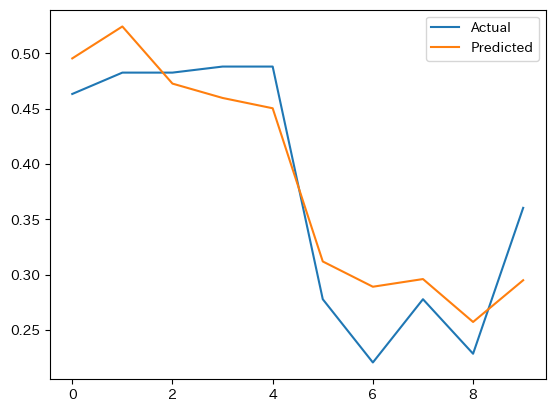

In [66]:
# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_R_hip = DataLoader(train_dataset_R_hip, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_R_hip:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_R_hip)}')

# モデルをファイルに保存
torch.save(model.state_dict(), '開始2秒/all_TD_model/R_hip.pth')


from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_R_hip = torch.stack(test_target_tensor_list_R_hip)
test_dataset_R_hip = TensorDataset(test_input_tensor, test_target_tensor_R_hip)
test_loader_R_hip = DataLoader(test_dataset_R_hip, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_R_hip:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()



Epoch 1/80, Loss: 0.08565427674256715
Epoch 2/80, Loss: 0.05487965920679131
Epoch 3/80, Loss: 0.04820591444676115
Epoch 4/80, Loss: 0.04562226906372
Epoch 5/80, Loss: 0.039215659378704866
Epoch 6/80, Loss: 0.03520704730795275
Epoch 7/80, Loss: 0.02899455683113979
Epoch 8/80, Loss: 0.028500439218905327
Epoch 9/80, Loss: 0.024399093191675263
Epoch 10/80, Loss: 0.020751642452286154
Epoch 11/80, Loss: 0.01776211655461206
Epoch 12/80, Loss: 0.015177837990683002
Epoch 13/80, Loss: 0.013773656776057902
Epoch 14/80, Loss: 0.013391709601595511
Epoch 15/80, Loss: 0.010851320223566894
Epoch 16/80, Loss: 0.00895099905313662
Epoch 17/80, Loss: 0.007720154475382103
Epoch 18/80, Loss: 0.007361459085687377
Epoch 19/80, Loss: 0.006772749772091775
Epoch 20/80, Loss: 0.006284281094301136
Epoch 21/80, Loss: 0.006053690376501979
Epoch 22/80, Loss: 0.005974606497929287
Epoch 23/80, Loss: 0.005781696092901312
Epoch 24/80, Loss: 0.004776104042147422
Epoch 25/80, Loss: 0.004412815644611703
Epoch 26/80, Loss: 0

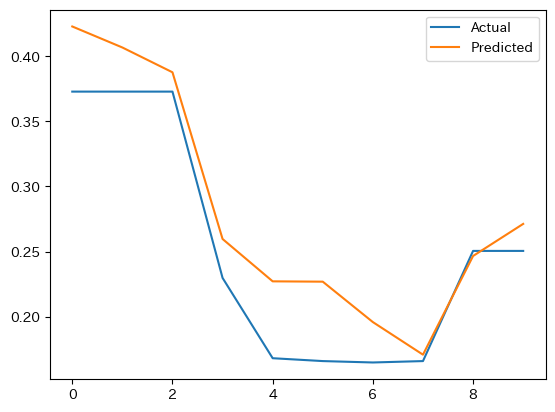

In [67]:
# DataLoaderの設定
train_loader_L_hip = DataLoader(train_dataset_L_hip, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_L_hip:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_L_hip)}')

# モデルをファイルに保存
torch.save(model.state_dict(), '開始2秒/all_TD_model/L_hip.pth')


from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_L_hip = torch.stack(test_target_tensor_list_L_hip)
test_dataset_L_hip = TensorDataset(test_input_tensor, test_target_tensor_L_hip)
test_loader_L_hip = DataLoader(test_dataset_L_hip, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_L_hip:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()



Epoch 1/80, Loss: 0.09583175439743241
Epoch 2/80, Loss: 0.0626940293601438
Epoch 3/80, Loss: 0.05698531643129492
Epoch 4/80, Loss: 0.05104087332869651
Epoch 5/80, Loss: 0.0456578677178515
Epoch 6/80, Loss: 0.04171622603319716
Epoch 7/80, Loss: 0.0380583095157182
Epoch 8/80, Loss: 0.03349961349494924
Epoch 9/80, Loss: 0.02980659194653339
Epoch 10/80, Loss: 0.02609384333803763
Epoch 11/80, Loss: 0.023049848074626983
Epoch 12/80, Loss: 0.020694367650746552
Epoch 13/80, Loss: 0.01827019720394445
Epoch 14/80, Loss: 0.015606522660154906
Epoch 15/80, Loss: 0.014836754692582665
Epoch 16/80, Loss: 0.013115538701873703
Epoch 17/80, Loss: 0.012213745615421677
Epoch 18/80, Loss: 0.010355062723679271
Epoch 19/80, Loss: 0.00887444481252454
Epoch 20/80, Loss: 0.007641932753034067
Epoch 21/80, Loss: 0.007325605111110057
Epoch 22/80, Loss: 0.007283353538371754
Epoch 23/80, Loss: 0.007963188822105078
Epoch 24/80, Loss: 0.006876646203220583
Epoch 25/80, Loss: 0.006155219343233498
Epoch 26/80, Loss: 0.005

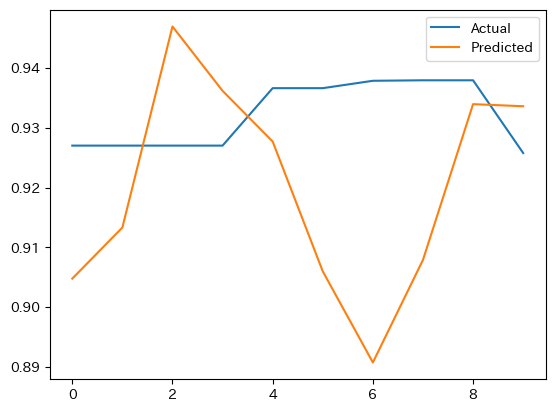

In [68]:
# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_R_ankle = DataLoader(train_dataset_R_ankle, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_R_ankle:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_R_ankle)}')

# モデルをファイルに保存
torch.save(model.state_dict(), '開始2秒/all_TD_model/R_ankle.pth')


from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_R_ankle = torch.stack(test_target_tensor_list_R_ankle)
test_dataset_R_ankle = TensorDataset(test_input_tensor, test_target_tensor_R_ankle)
test_loader_R_ankle = DataLoader(test_dataset_R_ankle, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_R_ankle:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()



Epoch 1/80, Loss: 0.09499107418352523
Epoch 2/80, Loss: 0.06426832809793907
Epoch 3/80, Loss: 0.05500334879440775
Epoch 4/80, Loss: 0.04825702315955727
Epoch 5/80, Loss: 0.0445171046245085
Epoch 6/80, Loss: 0.0388321049275092
Epoch 7/80, Loss: 0.03688250936102122
Epoch 8/80, Loss: 0.031161144283955833
Epoch 9/80, Loss: 0.02802993737637351
Epoch 10/80, Loss: 0.024637762897638558
Epoch 11/80, Loss: 0.021423199393051727
Epoch 12/80, Loss: 0.018469041215733218
Epoch 13/80, Loss: 0.01696270869590866
Epoch 14/80, Loss: 0.01461195564084691
Epoch 15/80, Loss: 0.01243392147659675
Epoch 16/80, Loss: 0.010956845222270332
Epoch 17/80, Loss: 0.011379986205670618
Epoch 18/80, Loss: 0.009307753306991379
Epoch 19/80, Loss: 0.00782869224703927
Epoch 20/80, Loss: 0.009183385682610524
Epoch 21/80, Loss: 0.007832711518346682
Epoch 22/80, Loss: 0.00587033227728984
Epoch 23/80, Loss: 0.006070715382849638
Epoch 24/80, Loss: 0.005799965271035949
Epoch 25/80, Loss: 0.005489742537801289
Epoch 26/80, Loss: 0.005

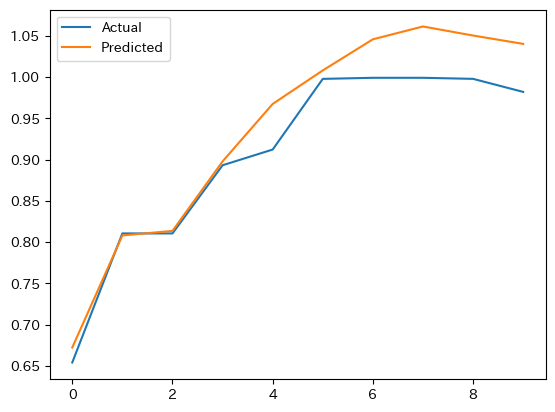

In [69]:
# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_L_ankle = DataLoader(train_dataset_L_ankle, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_L_ankle:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_L_ankle)}')

# モデルをファイルに保存
torch.save(model.state_dict(), '開始2秒/all_TD_model/L_ankle.pth')

from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_L_ankle = torch.stack(test_target_tensor_list_L_ankle)
test_dataset_L_ankle = TensorDataset(test_input_tensor, test_target_tensor_L_ankle)
test_loader_L_ankle = DataLoader(test_dataset_L_ankle, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_L_ankle:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()



Epoch 1/80, Loss: 0.09334875739837094
Epoch 2/80, Loss: 0.06319830184755613
Epoch 3/80, Loss: 0.04952423687879202
Epoch 4/80, Loss: 0.04634533332539114
Epoch 5/80, Loss: 0.03875428449184676
Epoch 6/80, Loss: 0.03278051524764704
Epoch 7/80, Loss: 0.029174935912137767
Epoch 8/80, Loss: 0.02512636674502537
Epoch 9/80, Loss: 0.022585433308765217
Epoch 10/80, Loss: 0.018912307136509585
Epoch 11/80, Loss: 0.016523610913995
Epoch 12/80, Loss: 0.013670849002226157
Epoch 13/80, Loss: 0.012374035431418438
Epoch 14/80, Loss: 0.010406888537600299
Epoch 15/80, Loss: 0.009345387183504188
Epoch 16/80, Loss: 0.009617336380152715
Epoch 17/80, Loss: 0.00790054091818668
Epoch 18/80, Loss: 0.00703528742498985
Epoch 19/80, Loss: 0.0063508279825181665
Epoch 20/80, Loss: 0.006113950833245344
Epoch 21/80, Loss: 0.005070473218831612
Epoch 22/80, Loss: 0.0043397081495805566
Epoch 23/80, Loss: 0.00452100494513803
Epoch 24/80, Loss: 0.004286686335538219
Epoch 25/80, Loss: 0.004602437790649377
Epoch 26/80, Loss: 0

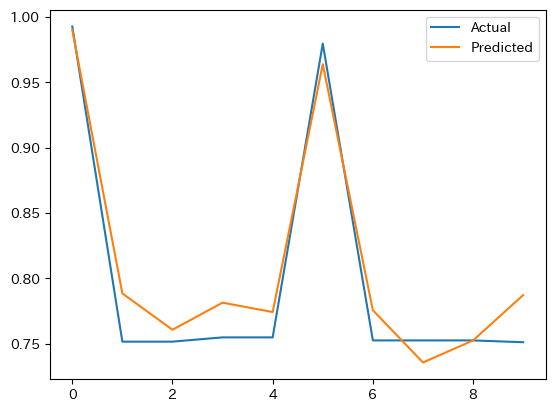

In [70]:
epochs = 80

# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_shoulder = DataLoader(train_dataset_shoulder, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_shoulder:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_shoulder)}')

torch.save(model.state_dict(), '開始2秒/all_TD_model/shoulder.pth')

from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_shoulder = torch.stack(test_target_tensor_list_shoulder)
test_dataset_shoulder = TensorDataset(test_input_tensor, test_target_tensor_shoulder)
test_loader_shoulder= DataLoader(test_dataset_shoulder, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_shoulder:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()


Epoch 1/80, Loss: 0.07715358753892214
Epoch 2/80, Loss: 0.04658596472926999
Epoch 3/80, Loss: 0.0404204944986382
Epoch 4/80, Loss: 0.036877539362196794
Epoch 5/80, Loss: 0.03386549202634031
Epoch 6/80, Loss: 0.0300588170835753
Epoch 7/80, Loss: 0.029263829511716664
Epoch 8/80, Loss: 0.02647699541049593
Epoch 9/80, Loss: 0.02404884801008715
Epoch 10/80, Loss: 0.021264745850916297
Epoch 11/80, Loss: 0.01938603774482974
Epoch 12/80, Loss: 0.01710330493761058
Epoch 13/80, Loss: 0.014753075277353239
Epoch 14/80, Loss: 0.013515651675617444
Epoch 15/80, Loss: 0.011760279518697205
Epoch 16/80, Loss: 0.010975433057805888
Epoch 17/80, Loss: 0.008642082516192903
Epoch 18/80, Loss: 0.00767081977867395
Epoch 19/80, Loss: 0.0073966097207178345
Epoch 20/80, Loss: 0.0061844457108346075
Epoch 21/80, Loss: 0.005728177948861883
Epoch 22/80, Loss: 0.005235890944455587
Epoch 23/80, Loss: 0.004774991884165392
Epoch 24/80, Loss: 0.004871328864433807
Epoch 25/80, Loss: 0.0041737133744125954
Epoch 26/80, Loss:

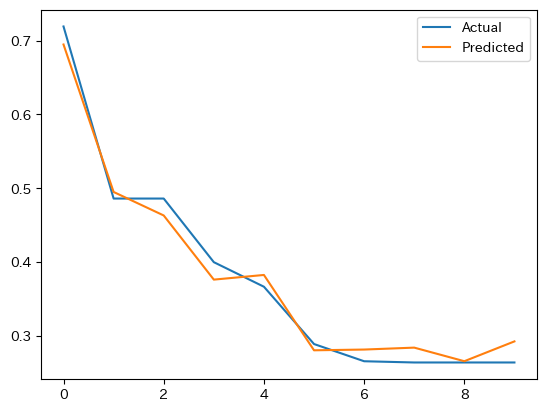

In [71]:
epochs = 80

# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_R_elbow = DataLoader(train_dataset_R_elbow, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_R_elbow:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_R_elbow)}')

torch.save(model.state_dict(), '開始2秒/all_TD_model/R_elbow.pth')

from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_R_elbow = torch.stack(test_target_tensor_list_R_elbow)
test_dataset_R_elbow = TensorDataset(test_input_tensor, test_target_tensor_R_elbow)
test_loader_R_elbow= DataLoader(test_dataset_R_elbow, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_R_elbow:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()


Epoch 1/80, Loss: 0.0789253504995968
Epoch 2/80, Loss: 0.05492700103567398
Epoch 3/80, Loss: 0.04686496323489364
Epoch 4/80, Loss: 0.041582300899849836
Epoch 5/80, Loss: 0.03817733014517244
Epoch 6/80, Loss: 0.03394221492525864
Epoch 7/80, Loss: 0.028512779606889988
Epoch 8/80, Loss: 0.0263328935410453
Epoch 9/80, Loss: 0.02285361501105111
Epoch 10/80, Loss: 0.018337451287746505
Epoch 11/80, Loss: 0.016527427228205094
Epoch 12/80, Loss: 0.01475706803624111
Epoch 13/80, Loss: 0.01301500418670382
Epoch 14/80, Loss: 0.010938561458290372
Epoch 15/80, Loss: 0.010087081036956316
Epoch 16/80, Loss: 0.0084340378926393
Epoch 17/80, Loss: 0.006764065503521855
Epoch 18/80, Loss: 0.005883185208737663
Epoch 19/80, Loss: 0.005509916725732274
Epoch 20/80, Loss: 0.0056094810973277235
Epoch 21/80, Loss: 0.0046660126830116565
Epoch 22/80, Loss: 0.004207680210700474
Epoch 23/80, Loss: 0.0038420532981574946
Epoch 24/80, Loss: 0.00445257006950171
Epoch 25/80, Loss: 0.004433962412356357
Epoch 26/80, Loss: 0

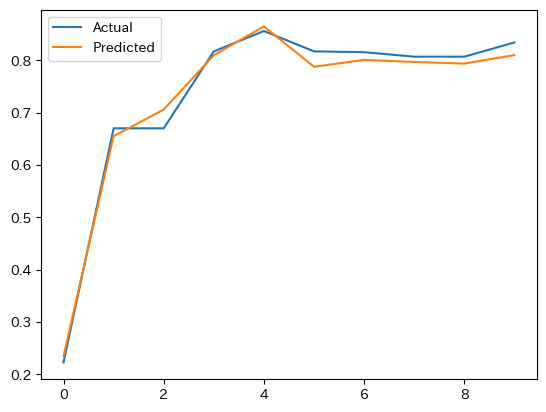

In [72]:
epochs = 80

# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_L_elbow = DataLoader(train_dataset_L_elbow, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_L_elbow:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_L_elbow)}')

torch.save(model.state_dict(), '開始2秒/all_TD_model/L_elbow.pth')

from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_L_elbow = torch.stack(test_target_tensor_list_L_elbow)
test_dataset_L_elbow = TensorDataset(test_input_tensor, test_target_tensor_L_elbow)
test_loader_L_elbow= DataLoader(test_dataset_L_elbow, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_L_elbow:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()


Epoch 1/80, Loss: 0.06824411557818852
Epoch 2/80, Loss: 0.04791733151507662
Epoch 3/80, Loss: 0.04115415803957075
Epoch 4/80, Loss: 0.03620600567466051
Epoch 5/80, Loss: 0.03057694899961914
Epoch 6/80, Loss: 0.026915989280327332
Epoch 7/80, Loss: 0.023547504727270022
Epoch 8/80, Loss: 0.019817193740763555
Epoch 9/80, Loss: 0.0168367260774532
Epoch 10/80, Loss: 0.014641860876134106
Epoch 11/80, Loss: 0.01287282289394257
Epoch 12/80, Loss: 0.011401473472582822
Epoch 13/80, Loss: 0.010652841184342083
Epoch 14/80, Loss: 0.009351366135202835
Epoch 15/80, Loss: 0.008199732971784833
Epoch 16/80, Loss: 0.00672330205877494
Epoch 17/80, Loss: 0.006028960346028995
Epoch 18/80, Loss: 0.005556023039096901
Epoch 19/80, Loss: 0.005397425343934213
Epoch 20/80, Loss: 0.005165671475170807
Epoch 21/80, Loss: 0.004378732899028396
Epoch 22/80, Loss: 0.004022496014168889
Epoch 23/80, Loss: 0.0038715579269697244
Epoch 24/80, Loss: 0.003720112703477346
Epoch 25/80, Loss: 0.0039502747436451855
Epoch 26/80, Los

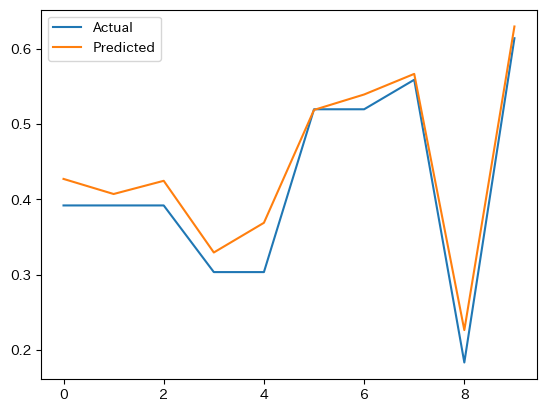

In [73]:
epochs = 80

# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_R_midhip = DataLoader(train_dataset_R_midhip, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_R_midhip:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_R_midhip)}')

torch.save(model.state_dict(), '開始2秒/all_TD_model/R_midhip.pth')

from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_R_midhip = torch.stack(test_target_tensor_list_R_midhip)
test_dataset_R_midhip = TensorDataset(test_input_tensor, test_target_tensor_R_midhip)
test_loader_R_midhip= DataLoader(test_dataset_R_midhip, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_R_midhip:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()


Epoch 1/80, Loss: 0.0749065305156652
Epoch 2/80, Loss: 0.04762690775938819
Epoch 3/80, Loss: 0.04146478092414912
Epoch 4/80, Loss: 0.036791672776851
Epoch 5/80, Loss: 0.03288694322881425
Epoch 6/80, Loss: 0.029432797285285896
Epoch 7/80, Loss: 0.02695093301227831
Epoch 8/80, Loss: 0.025064452245349447
Epoch 9/80, Loss: 0.02206997857744988
Epoch 10/80, Loss: 0.02026502744308743
Epoch 11/80, Loss: 0.01809878846871475
Epoch 12/80, Loss: 0.016226720094128545
Epoch 13/80, Loss: 0.014548629846414505
Epoch 14/80, Loss: 0.012497540302434234
Epoch 15/80, Loss: 0.011236750329470253
Epoch 16/80, Loss: 0.010037629976845229
Epoch 17/80, Loss: 0.009173332143167791
Epoch 18/80, Loss: 0.008514003839867947
Epoch 19/80, Loss: 0.007627228036845786
Epoch 20/80, Loss: 0.006745176582278955
Epoch 21/80, Loss: 0.00598277529144669
Epoch 22/80, Loss: 0.005394220278608898
Epoch 23/80, Loss: 0.004922091453125579
Epoch 24/80, Loss: 0.004618132643427363
Epoch 25/80, Loss: 0.004480759158962167
Epoch 26/80, Loss: 0.0

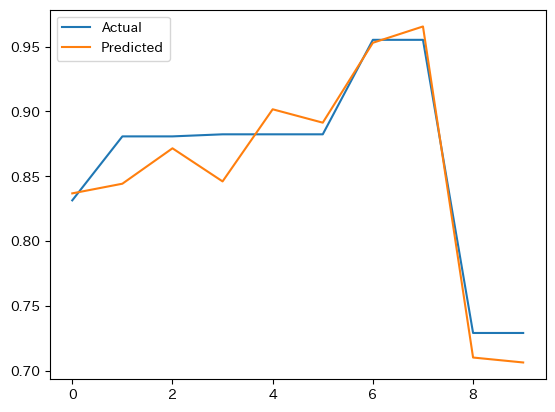

In [74]:
epochs = 80

# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_L_midhip = DataLoader(train_dataset_L_midhip, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_L_midhip:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_R_midhip)}')

torch.save(model.state_dict(), '開始2秒/all_TD_model/L_midhip.pth')

from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_L_midhip = torch.stack(test_target_tensor_list_L_midhip)
test_dataset_L_midhip = TensorDataset(test_input_tensor, test_target_tensor_L_midhip)
test_loader_L_midhip= DataLoader(test_dataset_L_midhip, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_L_midhip:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()


Epoch 1/80, Loss: 0.09200904483031762
Epoch 2/80, Loss: 0.056351538446858224
Epoch 3/80, Loss: 0.04346305040417978
Epoch 4/80, Loss: 0.036522929900063755
Epoch 5/80, Loss: 0.030408673086110033
Epoch 6/80, Loss: 0.02660292637038358
Epoch 7/80, Loss: 0.02166389108193224
Epoch 8/80, Loss: 0.018549527117664267
Epoch 9/80, Loss: 0.016233077455000793
Epoch 10/80, Loss: 0.014836600683886914
Epoch 11/80, Loss: 0.011664090691550855
Epoch 12/80, Loss: 0.010382937397878036
Epoch 13/80, Loss: 0.010058825651895087
Epoch 14/80, Loss: 0.011044626226285987
Epoch 15/80, Loss: 0.007480885175082496
Epoch 16/80, Loss: 0.005924417636703569
Epoch 17/80, Loss: 0.005543448807538286
Epoch 18/80, Loss: 0.004956849958939506
Epoch 19/80, Loss: 0.004322135191961851
Epoch 20/80, Loss: 0.0037420170853176534
Epoch 21/80, Loss: 0.003726244042393513
Epoch 22/80, Loss: 0.004174457298885404
Epoch 23/80, Loss: 0.003852584636793589
Epoch 24/80, Loss: 0.003274529564823843
Epoch 25/80, Loss: 0.003069801464759927
Epoch 26/80,

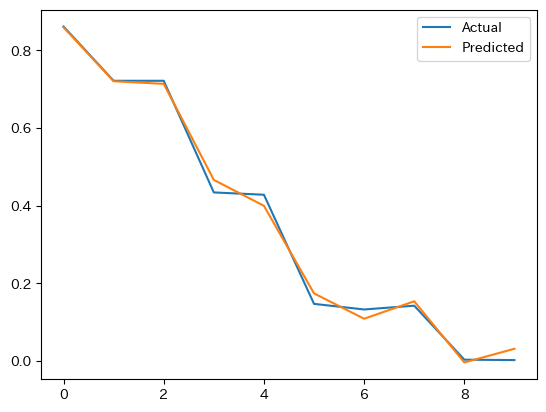

In [75]:
epochs = 80

# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_neck = DataLoader(train_dataset_neck, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_neck:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_neck)}')

torch.save(model.state_dict(), '開始2秒/all_TD_model/neck.pth')

from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_neck = torch.stack(test_target_tensor_list_neck)
test_dataset_neck = TensorDataset(test_input_tensor, test_target_tensor_neck)
test_loader_neck= DataLoader(test_dataset_neck, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_neck:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()


Epoch 1/80, Loss: 0.08852460814274885
Epoch 2/80, Loss: 0.05851146908144668
Epoch 3/80, Loss: 0.052918966396842806
Epoch 4/80, Loss: 0.04653390758347946
Epoch 5/80, Loss: 0.041385032661872254
Epoch 6/80, Loss: 0.036419765256817956
Epoch 7/80, Loss: 0.031843457532456924
Epoch 8/80, Loss: 0.028165088067926353
Epoch 9/80, Loss: 0.023201822016584737
Epoch 10/80, Loss: 0.020832173278246394
Epoch 11/80, Loss: 0.01715468536844786
Epoch 12/80, Loss: 0.01550711243180558
Epoch 13/80, Loss: 0.013327009868269889
Epoch 14/80, Loss: 0.01354903171199313
Epoch 15/80, Loss: 0.012151302689927439
Epoch 16/80, Loss: 0.009984760123700484
Epoch 17/80, Loss: 0.009048698061519074
Epoch 18/80, Loss: 0.007789083321557741
Epoch 19/80, Loss: 0.006860400738437945
Epoch 20/80, Loss: 0.006468156792852915
Epoch 21/80, Loss: 0.005767283606080891
Epoch 22/80, Loss: 0.005528809796976646
Epoch 23/80, Loss: 0.005383861120427542
Epoch 24/80, Loss: 0.004544409340155081
Epoch 25/80, Loss: 0.004066018895164189
Epoch 26/80, Lo

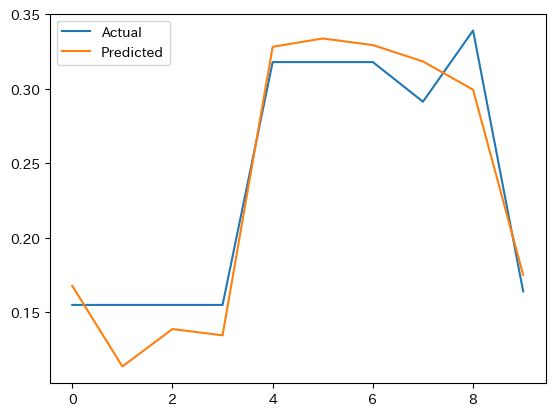

In [76]:
# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_R_knee = DataLoader(train_dataset_R_knee, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_R_knee:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_R_knee)}')

# モデルをファイルに保存
torch.save(model.state_dict(), '開始2秒/all_TD_model/R_knee.pth')

from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_R_knee = torch.stack(test_target_tensor_list_R_knee)
test_dataset_R_knee = TensorDataset(test_input_tensor, test_target_tensor_R_knee)
test_loader_R_knee = DataLoader(test_dataset_R_knee, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_R_knee:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()



Epoch 1/80, Loss: 0.10376726732420824
Epoch 2/80, Loss: 0.06769453866720836
Epoch 3/80, Loss: 0.05775805821363819
Epoch 4/80, Loss: 0.05100597409255354
Epoch 5/80, Loss: 0.04548902649563461
Epoch 6/80, Loss: 0.0407053915796633
Epoch 7/80, Loss: 0.0337771917365716
Epoch 8/80, Loss: 0.03033019233396717
Epoch 9/80, Loss: 0.02552995002704518
Epoch 10/80, Loss: 0.022958801017404912
Epoch 11/80, Loss: 0.018113663455473737
Epoch 12/80, Loss: 0.015427852948617433
Epoch 13/80, Loss: 0.012169731245025168
Epoch 14/80, Loss: 0.010942942942270363
Epoch 15/80, Loss: 0.009035176812816206
Epoch 16/80, Loss: 0.008892135723288072
Epoch 17/80, Loss: 0.008052524663601538
Epoch 18/80, Loss: 0.006629527917941424
Epoch 19/80, Loss: 0.006161355711847319
Epoch 20/80, Loss: 0.006026098321703258
Epoch 21/80, Loss: 0.006065137343581804
Epoch 22/80, Loss: 0.00595776134594133
Epoch 23/80, Loss: 0.005274657583877388
Epoch 24/80, Loss: 0.00496587545866025
Epoch 25/80, Loss: 0.004342282248834083
Epoch 26/80, Loss: 0.0

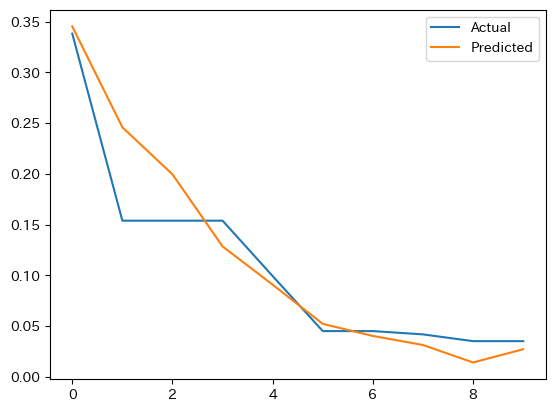

In [77]:
# DataLoaderの設定（例：R_kneeに対する訓練用）
train_loader_L_knee = DataLoader(train_dataset_L_knee, batch_size=batch_size, shuffle=True)

# モデルをGPUに移動（CUDAが利用可能な場合）
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# 訓練ループ
for epoch in range(epochs):
    model.train()  # モデルを訓練モードに設定
    epoch_loss = 0  # エポックの損失を追跡

    for x, y in train_loader_L_knee:
        x, y = x.to(device), y.to(device)  # データを同じデバイスに移動
        optimizer.zero_grad()  # オプティマイザの勾配をゼロにリセット

        # 前向き伝播
        y_pred = model(x)

        # 損失の計算
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()

        # 後ろ向き伝播とパラメータの更新
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader_L_knee)}')

# モデルをファイルに保存
torch.save(model.state_dict(), '開始2秒/all_TD_model/L_knee.pth')



from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt

# テストデータセットの準備
test_input_tensor = torch.stack(test_input_tensor_list)
test_target_tensor_L_knee = torch.stack(test_target_tensor_list_L_knee)
test_dataset_L_knee = TensorDataset(test_input_tensor, test_target_tensor_L_knee)
test_loader_L_knee = DataLoader(test_dataset_L_knee, batch_size=1)

model.eval()  # モデルを評価モードに設定
sample_loss = []
all_predictions = []
all_targets = []

# テストループ
for x, y in test_loader_L_knee:
    x = x.to(device)  # デバイスにデータを移動
    y_pred = model(x)
    loss = criterion(y_pred, y.to(device))
    sample_loss.append(loss.item())
    all_predictions.append(y_pred.cpu().detach().numpy())
    all_targets.append(y.numpy())

import numpy as np
from dtw import dtw

# ここで all_predictions と all_targets を定義します。
# それぞれの要素は異なる形状のリストと仮定します。
# 例: all_predictions = [ [...], [...], ...]
#     all_targets = [ [...], [...], ...]

# ユークリッド距離を計算する関数
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

dtw_scores = []
for i in range(len(all_predictions)):
    # 各要素をNumPy配列に変換してからDTWを計算
    prediction_array = np.array(all_predictions[i])
    target_array = np.array(all_targets[i])
    
    dtw_result = dtw(prediction_array, target_array, dist=euclidean_distance)
    
    # タプルから距離を取得
    dtw_distance = dtw_result[0]
    dtw_scores.append(dtw_distance)

average_dtw_score = np.mean(dtw_scores)

print(average_dtw_score)

# 一つのテストデータに対する正解値と予測値をプロット
plt.plot(all_targets[0][0], label='Actual')
plt.plot(all_predictions[0][0], label='Predicted')
plt.legend()
plt.show()

